In [29]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.utils import plot_model
from keras.applications.mobilenet_v2 import MobileNetV2

from IPython.display import HTML
from base64 import b64encode

In [ ]:
def Play_Video(filepath):
    html = ''
    video = open(filepath, 'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    return HTML(html)

In [ ]:
NonViolnceVideos_Dir = "./Dataset/NonViolence/"
ViolnceVideos_Dir = "./Dataset/Violence/"

In [ ]:
NonViolence_files_names_list = os.listdir(NonViolnceVideos_Dir)
Violence_files_names_list = os.listdir(ViolnceVideos_Dir)

In [ ]:
Random_NonViolence_Video = random.choice(NonViolence_files_names_list)
Random_Violence_Video = random.choice(Violence_files_names_list)

In [ ]:
Play_Video(f"{NonViolnceVideos_Dir}/{Random_NonViolence_Video}")

In [ ]:
Play_Video(f"{ViolnceVideos_Dir}/{Random_Violence_Video}")

In [12]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 16

In [13]:
DATASET_DIR = "./Dataset/"

In [14]:
CLASSES_LIST = ["NonViolence", "Violence"]

In [15]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [16]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [17]:
features, labels, video_files_paths = create_dataset()
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_files_paths)

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [18]:
features, labels, video_files_paths = np.load("features.npy"), np.load("labels.npy"), np.load("video_files_paths.npy")

In [19]:
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [20]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(630, 16, 64, 64, 3) (630, 2)
(70, 16, 64, 64, 3) (70, 2)


In [21]:
mobilenet = MobileNetV2(include_top=False, weights="imagenet")
mobilenet.trainable = True

In [22]:
for layer in mobilenet.layers[:-40]:
    layer.trainable = False

In [23]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(mobilenet))
    model.add(Dropout(0.25))
    model.add(TimeDistributed(Flatten()))

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(Dropout(0.25))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.summary()
    return model

In [27]:
MoBiLSTM_model = create_model()
plot_model(MoBiLSTM_model, to_file='MobBiLSTM_model_structure_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 16, 2, 2, 1280)   2257984   
 tributed)                                                       
                                                                 
 dropout_12 (Dropout)        (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_5 (TimeDis  (None, 16, 5120)         0         
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               1319168   
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                      

In [30]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [31]:
model_checkpoint = ModelCheckpoint('model_checkpoint.h5', save_best_only=True)

In [32]:
# Compile the model
MoBiLSTM_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

In [33]:
# Training with callbacks
MobBiLSTM_model_history = MoBiLSTM_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback, reduce_lr, model_checkpoint])

Epoch 1/50
63/63 [==============================] - 34s 135ms/step - loss: 0.6973 - accuracy: 0.5159 - val_loss: 0.6766 - val_accuracy: 0.5714 - lr: 0.0100
Epoch 2/50
63/63 [==============================] - 5s 73ms/step - loss: 0.6885 - accuracy: 0.5595 - val_loss: 0.6376 - val_accuracy: 0.7540 - lr: 0.0100
Epoch 3/50
63/63 [==============================] - 4s 71ms/step - loss: 0.6439 - accuracy: 0.6290 - val_loss: 0.5573 - val_accuracy: 0.8571 - lr: 0.0100
Epoch 4/50
63/63 [==============================] - 4s 69ms/step - loss: 0.5256 - accuracy: 0.7937 - val_loss: 0.3982 - val_accuracy: 0.8571 - lr: 0.0100
Epoch 5/50
63/63 [==============================] - 4s 71ms/step - loss: 0.3987 - accuracy: 0.8631 - val_loss: 0.2869 - val_accuracy: 0.8651 - lr: 0.0100
Epoch 6/50
63/63 [==============================] - 5s 72ms/step - loss: 0.2977 - accuracy: 0.8889 - val_loss: 0.2269 - val_accuracy: 0.9127 - lr: 0.0100
Epoch 7/50
63/63 [==============================] - 4s 62ms/step - loss: 0

In [34]:
model_evaluation_history = MoBiLSTM_model.evaluate(features_test, labels_test)

3/3 [==============================] - 1s 44ms/step - loss: 0.0399 - accuracy: 0.9857


In [35]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

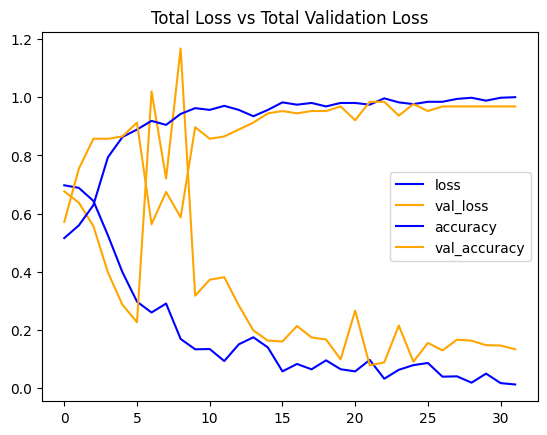

In [36]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [37]:
labels_predict = MoBiLSTM_model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(labels_test, axis=1)

3/3 [==============================] - 2s 38ms/step


In [38]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9857142857142858


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

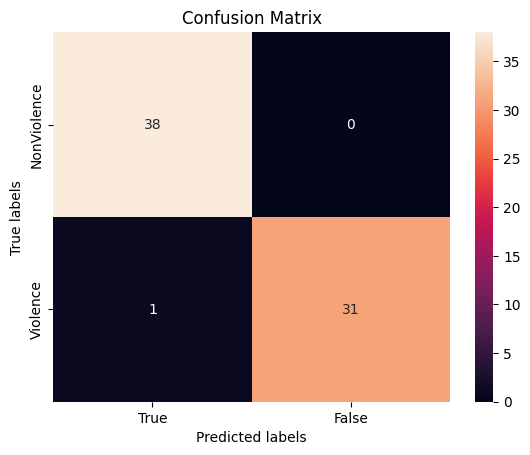

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [40]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal, labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99        38
           1       1.00      0.97      0.98        32

    accuracy                           0.99        70
   macro avg       0.99      0.98      0.99        70
weighted avg       0.99      0.99      0.99        70



In [41]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 12)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

plt.style.use("default")

In [42]:
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20, 15))
    video_reader = cv2.VideoCapture(pred_video_path)
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    random_range = sorted(random.sample(range(SEQUENCE_LENGTH, frames_count), 12))

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(5, 4, counter)
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)
        ok, frame = video_reader.read()

        if not ok:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        ax.figure.set_size_inches(20, 20)
        plt.tight_layout()

    video_reader.release()

In [43]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)
output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

1/1 [==============================] - 0s 22ms/step


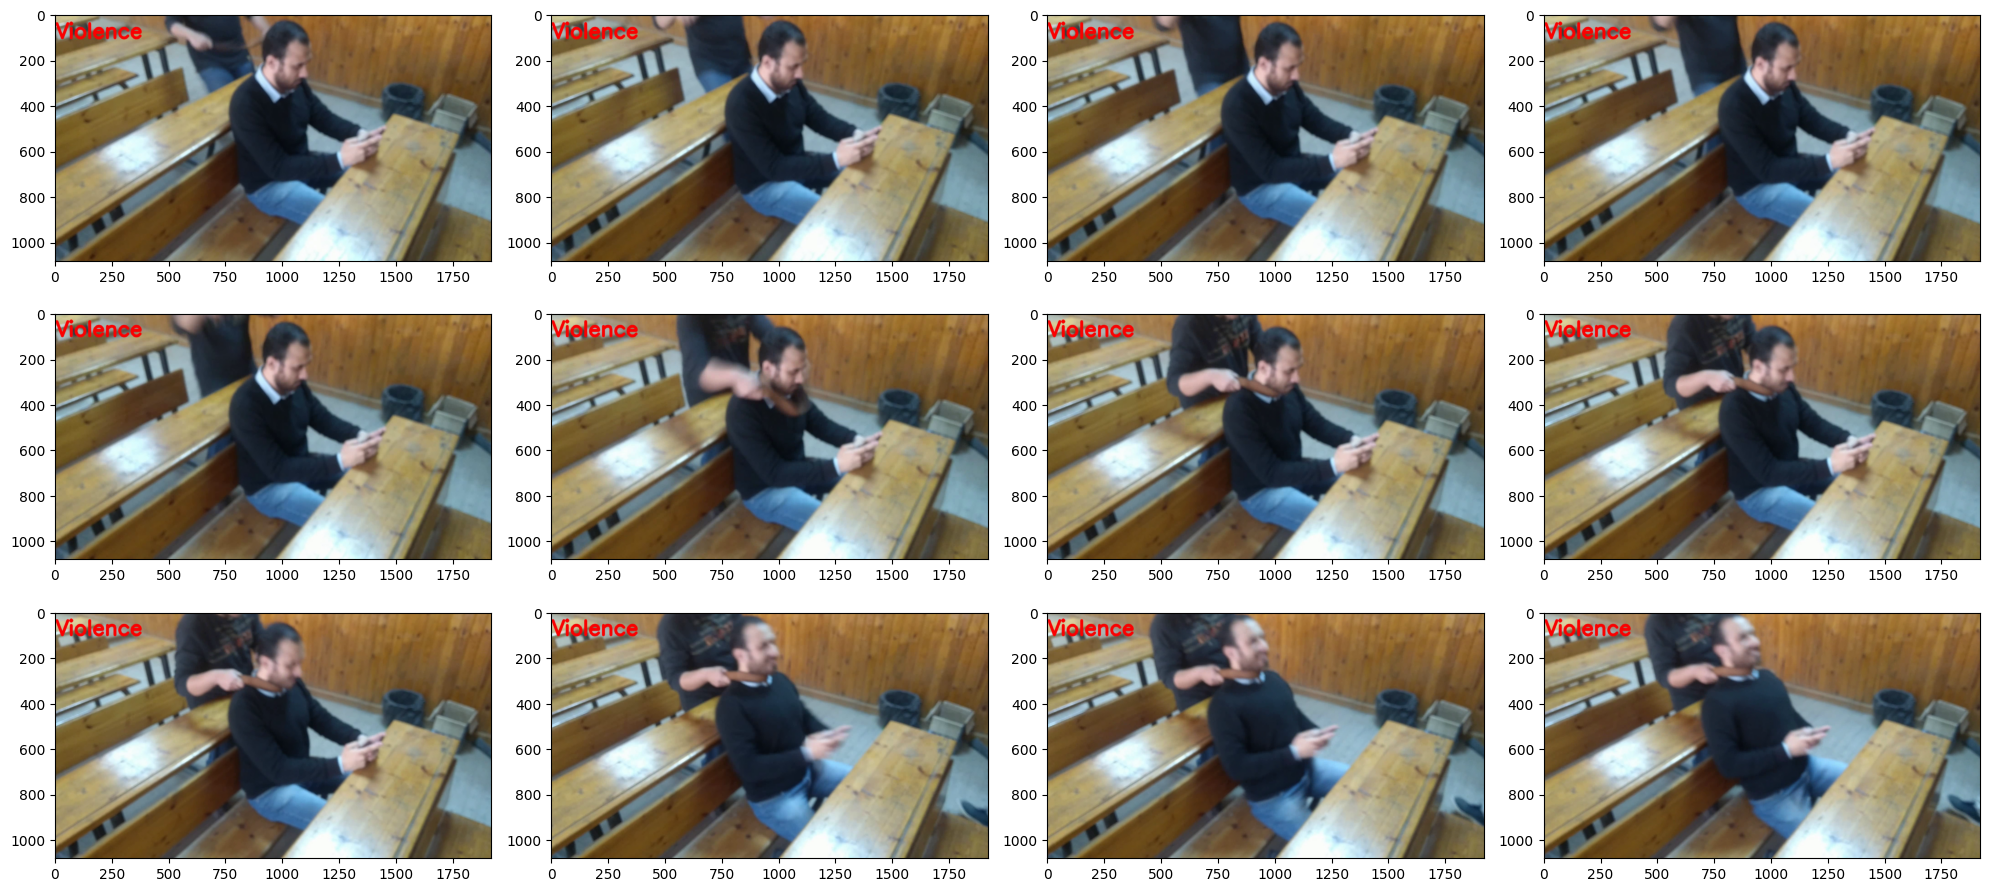

In [44]:
input_video_file_path = "Dataset/Violence/V_10.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
show_pred_frames(output_video_file_path)
Play_Video(input_video_file_path)

1/1 [==============================] - 0s 21ms/step


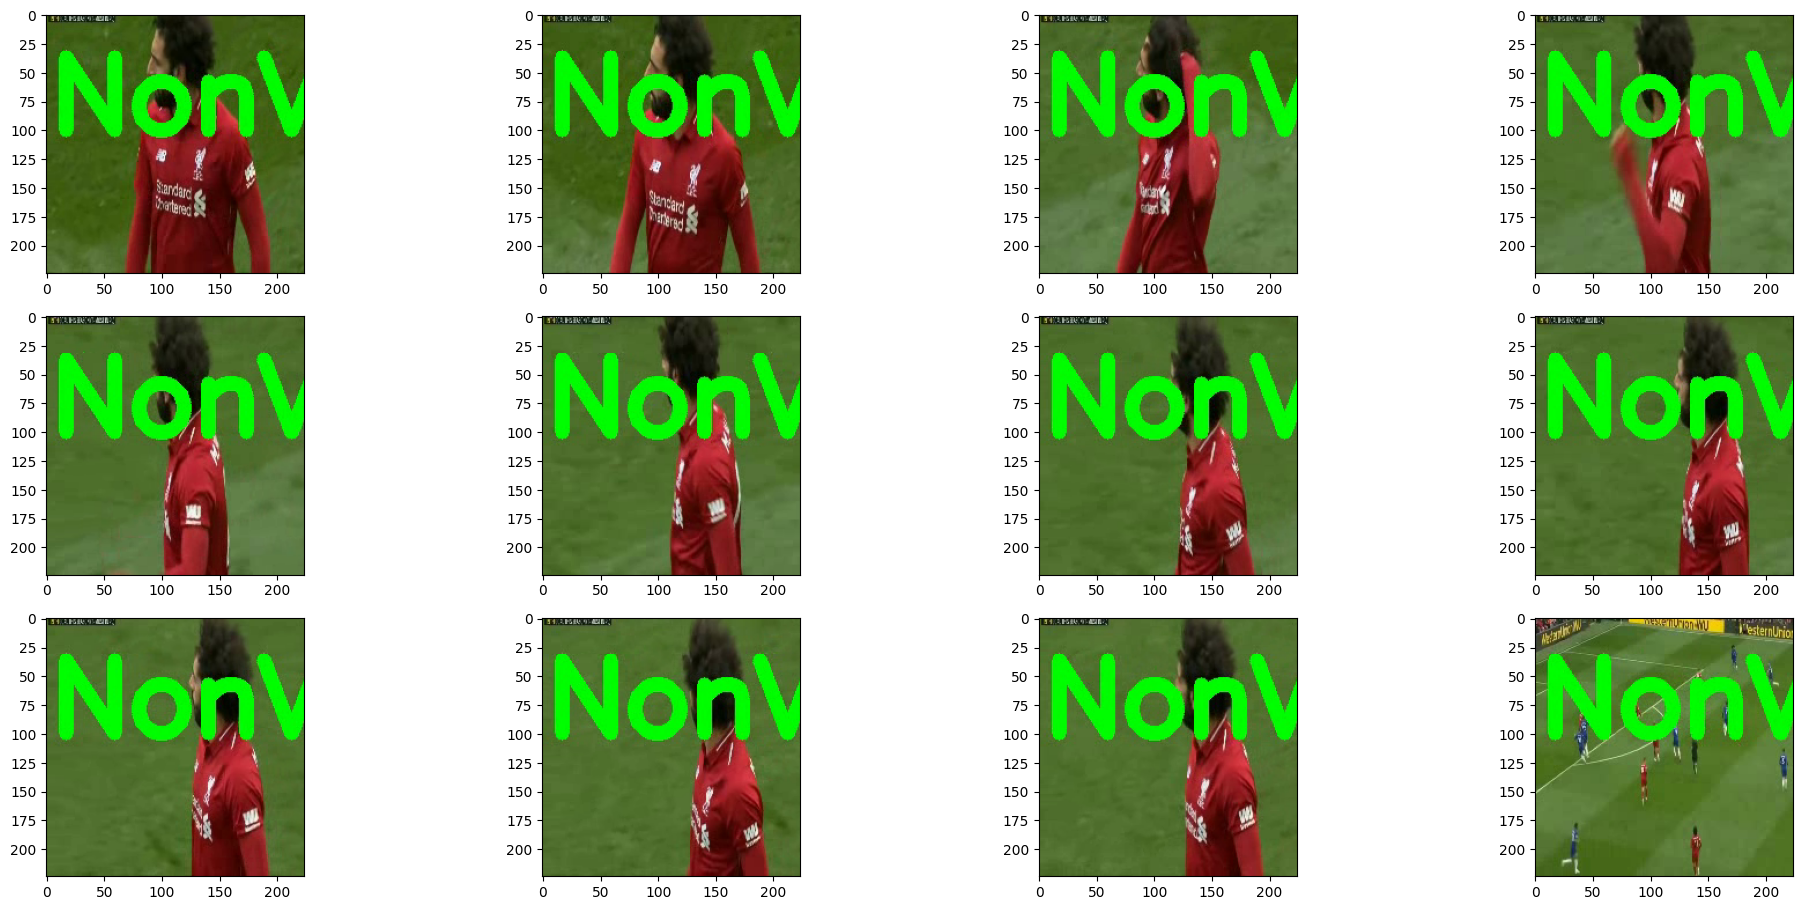

In [46]:
input_video_file_path = "Dataset/NonViolence/NV_120.mp4"
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
show_pred_frames(output_video_file_path)
Play_Video(input_video_file_path)

In [47]:
def predict_video(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis=0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()


In [48]:
!pip install pytube

     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------------- ------------------------ 20.5/57.6 kB 330.3 kB/s eta 0:00:01
     --------------------------------- ---- 51.2/57.6 kB 525.1 kB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 378.8 kB/s eta 0:00:00


In [49]:
from pytube import YouTube

def predict_video_from_url(video_url, sequence_length=16):
    try:
        # Get YouTube video details using pytube
        youtube_video = YouTube(video_url)
        video_stream = youtube_video.streams.filter(file_extension="mp4").first()
        video_stream_url = video_stream.url

        # Perform prediction on the video
        predict_video(video_stream_url, sequence_length)

    except Exception as e:
        print(f"Error: {e}")

In [50]:
user_video_url = "https://www.youtube.com/watch?v=QC8iQqtG0hg&pp=ygUPNSBzZWNvbmRzIHZpZGVv"
predict_video_from_url(user_video_url)

1/1 [==============================] - 0s 22ms/step
Predicted: NonViolence
Confidence: 0.9670588374137878


In [51]:
args_model = "modelnew.h5"
MoBiLSTM_model.save(args_model)

In [52]:
loaded_model = tf.keras.models.load_model(args_model)